# V15 vs V20 vs V20X

This notebook generates the plots and results from the `V15 vs V20` section of the manuscript, as well as the `V15 vs V20X` section.

---

# 1. How do the fields themselves change when going from V15 to V20?

In [8]:
import xarray as xr
import pandas as pd
def calculate_delta_field(filename,parameter):
    
    
    """
    Function to determine the change in a parameter when going from V15 to V20
    """
    
    root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
    version = ['v015', 'v020']
    
    ds = [] #Array to hold results
    for v in version:
        path = root+f'climate.{v}/climate.{v}/639l_2/{filename}'
        ds_i= xr.open_dataset(path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName':parameter}) #only want this one parameter
        
        ds.append(ds_i)
        
    #Take the difference, and make it a nice pandas df    
    delta_field = ds[1] - ds[0] #V20 - V15
    delta_field =  delta_field.assign_coords({"longitude": (((delta_field.longitude + 180) % 360) - 180)}) #long3 ---> long1
    delta_field = delta_field.to_dataframe().reset_index()
    
    V20_df = ds[1].to_dataframe().reset_index()
    V15_df = ds[0].to_dataframe().reset_index()

    if parameter == '10si': #seaice shortname is inverse to variable name
        parameter='si10'
    
    delta_field[f'V15_{parameter}'] = V15_df[parameter]
    delta_field[f'V20_{parameter}'] = V20_df[parameter]
    delta_field = delta_field.rename(columns={f'{parameter}': f'change_in_{parameter}'})
    delta_field[f'percentage_change_in_{parameter}'] = (delta_field[f'V20_{parameter}'] - delta_field[f'V15_{parameter}']) / delta_field[f'V15_{parameter}']

    return delta_field


In [5]:
#Calculate all the delta fields i.e. the change in parameter V15-->V20
clake_delta_field  = calculate_delta_field('clake','cl')        #How does cl change?
seaice_delta_field = calculate_delta_field('cicecap','10si')    #How does seaice change
cvh_delta_field    = calculate_delta_field('cvh','cvh')         #How does cvh change?
cvl_delta_field    = calculate_delta_field('cvl','cvl')         #How does cvl change
lsm_delta_field    = calculate_delta_field('lsmoro','lsm')      #How does lsm change?
dl_delta_field     = calculate_delta_field('lakedl','dl')       #How does lake depth change?

In [9]:
#Bring all the delta fields together
change_in_fields = pd.concat([clake_delta_field,seaice_delta_field,cvh_delta_field,cvl_delta_field,lsm_delta_field,dl_delta_field],axis=1)
change_in_fields = change_in_fields.loc[:,~change_in_fields.columns.duplicated()] #remove duplicated column names that arise due to the concat

In [11]:
    
def classify(x,tol):
    
    if abs(x) > tol:
        return True
    else:
        return False
    




#If the change in a variable is greater than tolerance (e.g. abs(cl) > tolerance), the change is marked as `significant`. 
#The "is significant"/"is not significant" boolean is then used is to define a grouping bitstring category.
#For lake depth dl, tolerance specifies the fracional change e.g. is the change in dl > 10%? 
tolerance = 0.1 

# Classify every grid point according to the delta fields
# First create extra boolean columns for whether the change in the field is significant, where significane is determined by `tolerance`     
for parameter in ['cl','si10','cvh','cvl','lsm']:
    change_in_fields[f'{parameter}_change_is_significant'] = change_in_fields.apply(lambda x : classify(x[f'change_in_{parameter}'],tolerance), axis = 1)
    
#handle dl separatley since this is not a fractional 0-1 features
change_in_fields[f'dl_change_is_significant'] = change_in_fields.apply(lambda x : classify(x[f'change_in_dl']/x[f'V15_dl'],tolerance), axis = 1)
    

In [13]:
        
def bit(x):
    
    if x:
        return 1
    else:
        return 0


def bitstring(list_of_columns):
    
    bitstring=''
    for i in list_of_columns:
        idx = bit(i)
        bitstring += str(idx)
        
    return bitstring



# Then create a single group bitstring for all combinations of booleans
change_in_fields[f'bitstring'] = change_in_fields.apply(lambda x : bitstring( [x['cl_change_is_significant'],
                                                                               x['cvh_change_is_significant'],
                                                                               x['cvl_change_is_significant'],
                                                                               x['dl_change_is_significant'],
                                                                               x['lsm_change_is_significant'],
                                                                               x['si10_change_is_significant']    # ALPHABETICAL
                                                                              ]
                                                                               ), axis = 1)

Lets have a look at what this change in fields df looks like:

In [227]:
display(change_in_fields)
change_in_fields.to_pickle('tmp_data/change_in_fields.pkl')

,values,step,surface,latitude,longitude,change_in_cl,V15_cl,V20_cl,percentage_change_in_cl,heightAboveGround,...,V15_dl,V20_dl,percentage_change_in_dl,cl_change_is_significant,si10_change_is_significant,cvh_change_is_significant,cvl_change_is_significant,lsm_change_is_significant,dl_change_is_significant,bitstring
0,0,0 days,0.0,89.784877,0.0,0.0,0.0,0.0,NaN,10.0,...,4192.697266,4174.519531,-0.004336,False,False,False,False,False,False,000000
1,1,0 days,0.0,89.784877,20.0,0.0,0.0,0.0,NaN,10.0,...,4153.591797,4187.108398,0.008069,False,False,False,False,False,False,000000
2,2,0 days,0.0,89.784877,40.0,0.0,0.0,0.0,NaN,10.0,...,4152.509766,4205.511719,0.012764,False,False,False,False,False,False,000000
3,3,0 days,0.0,89.784877,60.0,0.0,0.0,0.0,NaN,10.0,...,4158.060547,4217.100586,0.014199,False,False,False,False,False,False,000000
4,4,0 days,0.0,89.784877,80.0,0.0,0.0,0.0,NaN,10.0,...,4157.796875,4219.924805,0.014943,False,False,False,False,False,False,000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542075,542075,0 days,0.0,-89.784877,-100.0,0.0,0.0,0.0,NaN,10.0,...,25.000000,10.000000,-0.600000,False,False,False,False,False,True,000100
542076,542076,0 days,0.0,-89.784877,-80.0,0.0,0.0,0.0,NaN,10.0,...,25.000000,10.000000,-0.600000,False,False,False,False,False,True,000100
542077,542077,0 days,0.0,-89.784877,-60.0,0.0,0.0,0.0,NaN,10.0,...,25.000000,10.000000,-0.600000,False,False,False,False,False,True,000100
542078,542078,0 days,0.0,-89.784877,-40.0,0.0,0.0,0.0,NaN,10.0,...,25.000000,10.000000,-0.600000,False,False,False,False,False,True,000100


This has 542080 rows. This is the number if grid points we expect given the reduced gaussian grid, and every one of thees grid points is classified accoridng to a 0.1 bit string.

---



# 2. Load the model predictions

In [15]:
    
def load_predictions(model):

    """For this model, load the predictions and determine the prediction error"""
    
    df = pd.read_parquet(model+'predictions.parquet')
    
    #Calculate some extra columns
    df['predicion_bias'] = df.MODIS_LST - df.predictions
    df['predicion_error'] = abs(df.MODIS_LST - df.predictions)


    print("Mean/Median/Std prediction bias:", df['predicion_bias'].mean(), df['predicion_bias'].median(),df['predicion_bias'].std())
    print("Mean/Median/Std prediction error:", df['predicion_error'].mean(), df['predicion_error'].median(),df['predicion_error'].std())

    #Average predictions and errors over the year
    df_grouped = df.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() 


    return df,df_grouped



In [18]:
V15_model =  '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V15_2016_augmented/'
V20_model =  '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V20_2016_augmented/'


print ('----------V15----------')
V15_predictions,V15_predictions_averaged = load_predictions(V15_model) #averaged = averaged over the year
print ('----------V20----------')
V20_predictions,V20_predictions_averaged = load_predictions(V20_model)

----------V15----------
Mean/Median/Std prediction bias: -0.041747708 0.10055542 4.081224
Mean/Median/Std prediction error: 3.0393808 2.3208313 2.7240207
----------V20----------
Mean/Median/Std prediction bias: 0.13015294 0.26712036 4.0542684
Mean/Median/Std prediction error: 3.0233936 2.3095398 2.7042806


Ok we can see that the predictions are pretty similar when averaged over the entire earth. Lets bring the V15 and V20 predictions together into a single df: 

In [20]:
#Create a new df that will just hold the differences   
data = {'latitude_ERA':   V20_predictions_averaged.latitude_ERA, 
        'longitude_ERA':  V20_predictions_averaged.longitude_ERA,
        'MODIS_LST':      V20_predictions_averaged.MODIS_LST,
        'V15_prediction': V15_predictions_averaged.predictions,
        'V20_prediction': V20_predictions_averaged.predictions,
        'V15_error':      V15_predictions_averaged.predicion_error,
        'V20_error':      V20_predictions_averaged.predicion_error,
        'delta':          V20_predictions_averaged.predicion_error - V15_predictions_averaged.predicion_error}
V20_V15_annual_average = pd.DataFrame(data)   

What does this look like?

In [23]:
V20_V15_annual_average

,latitude_ERA,longitude_ERA,MODIS_LST,V15_prediction,V20_prediction,V15_error,V20_error,delta
0,-70.117048,-75.75,256.971771,260.839691,258.764496,5.176608,4.774697,-0.401910
1,-70.117048,-75.00,256.868408,260.022491,257.034821,4.589613,4.524141,-0.065473
2,-70.117048,-72.00,255.929306,258.782562,257.770081,5.802632,5.922895,0.120263
3,-70.117048,-71.25,254.781509,258.479736,257.310944,5.732193,5.754484,0.022292
4,-70.117048,-70.50,255.270538,258.035889,258.086243,6.000848,5.888017,-0.112831
...,...,...,...,...,...,...,...,...
149805,70.117048,168.00,264.279388,264.181641,264.485321,3.836673,3.708954,-0.127719
149806,70.117048,168.75,263.243958,263.457367,263.287903,3.779803,3.540926,-0.238878
149807,70.117048,170.25,266.316162,262.494171,262.690735,5.866361,5.818576,-0.047784
149808,70.117048,171.00,266.383087,264.283325,264.261658,5.195374,5.332411,0.137036


Note that we have < the ~500k rows that we had above since we dont have observations for every grid point (e.g. the sea!)

Now join in this new df to the `change_in_fields` df so we can get a category for every observed grid point:

In [24]:
#Apply the mask to the global error_delta_field from earlier
V20_V15_annual_average_categorized = pd.merge(V20_V15_annual_average,change_in_fields,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.

And lets group by the bitstring to get some per-category numbers

In [32]:
from scipy.stats import ttest_ind
import numpy as np

def significance_test(v1,v2):
    try:
        return ttest_ind(v1, v2)
    except:
        return np.nan

def significance_boolean(x):
    
    try:
        pval = x[-1]
    except:
        #Nans are not subscriptable
        return 'Insignificant'
    
    if (pval > 0.01) or np.isnan(pval): 
        return 'Insignificant'
    else:
        return 'Significant'
    

#Classification table. For each group/bitstring surface some numbers
classification_table                                = V20_V15_annual_average_categorized.groupby('bitstring').agg(**{'Number of Pixels':pd.NamedAgg('delta','size'),'AverageDelta':pd.NamedAgg('delta','mean')})     # For each group, count number of pixels and get the average delta      
classification_table["Percentage"]                  = 100.0* classification_table['Number of Pixels'] / sum(classification_table["Number of Pixels"])                                            # Express number of pixels as a percentage
classification_table['Stats (t-statistic,p-value)'] = V20_V15_annual_average_categorized.groupby('bitstring').apply(lambda x: significance_test(x['V15_error'], x['V20_error']))                                     # For each group, do a ttest between the V15_errors and the V20_errors
classification_table['Significant Change?']         = classification_table['Stats (t-statistic,p-value)'].apply(lambda x: significance_boolean(x))

display(classification_table[['Number of Pixels', 'Percentage','AverageDelta','Stats (t-statistic,p-value)','Significant Change?']].sort_values(by=['Significant Change?', 'Number of Pixels'],ascending=False))

#display(classification_table[['Number of Pixels', 'Percentage','AverageDelta','Stats (t-statistic,p-value)','Significant Change?']].sort_values(by=['Number of Pixels'],ascending=False))
#display(classification_table[['Number of Pixels','AverageDelta','Significant Change?']].sort_values(by=['Number of Pixels'],ascending=False))
#print ('-----------------------------------------------------------')

,Number of Pixels,Percentage,AverageDelta,"Stats (t-statistic,p-value)",Significant Change?
bitstring,,,,,
000100,135005,90.117482,-0.020074,"(5.6015351428002385, 2.1266764789306387e-08)",Significant
000000,9119,6.087044,-0.051633,"(3.025451326903979, 0.0024860820906935925)",Significant
100110,1512,1.009278,-0.336010,"(6.428846519940273, 1.4890045307006747e-10)",Significant
000101,834,0.556705,-0.146436,"(2.603472646240921, 0.00931042147086133)",Significant
011100,18,0.012015,3.905514,"(-4.470645229389644, 8.249553308371896e-05)",Significant
010100,13,0.008678,7.586944,"(-13.562981643142237, 9.521420939065104e-13)",Significant
101100,8,0.005340,0.486319,"(-3.3043994483637684, 0.00521642231127351)",Significant
100100,2392,1.596689,-0.053458,"(2.174490351294765, 0.02971719330884196)",Insignificant
000110,247,0.164876,-0.151713,"(1.5120205599473904, 0.1311706602165086)",Insignificant


# 2.1 Bitstring 100110

In [79]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import matplotlib.colors as mc
import matplotlib.colorbar as cb 


def RobinsonPlot(df,z,vmin,vmax,cmap,markersize,savefig):


    #Setup plotting env
    fig = plt.figure(figsize=[30,20])
    ax = plt.subplot(projection=ccrs.Robinson(central_longitude=0))
    cax = fig.add_axes([0.32, 0.11, 0.4, 0.0125])

    #Get data
    x = df['latitude_ERA']
    y = df['longitude_ERA']
    z1 = df[z]
    
    
    #Normalise
    norm = mc.Normalize(vmin=vmin, vmax=vmax)

    #Colorbar
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                               norm=norm,
                               orientation='horizontal'
                               )
    #Scatter points
    sc = ax.scatter(y,x,transform=ccrs.PlateCarree(),
                    s=markersize,
                    c=cmap(norm(z1)),
                    linewidths=1, 
                    alpha=.7)


    #Latitude cutoffs
    ax.plot([-180,180],[70,70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')
    ax.plot([-180,180],[-70,-70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')


    
    #Formatting
    cax.tick_params(labelsize=30)
    cax.set_xlabel(r'$\delta$K',fontsize=34)
    

    ax.coastlines()
    ax.set_aspect('auto') #Force projection aspect ratio
    
    ax.scatter(180,0,c='1',transform=ccrs.PlateCarree(),s=100,alpha=0.1) #invisible point to set plot limits. Hacky, but works OK.
    #ax.scatter(180,0,c='k')

    #ax.set_xlim(-180,180)

    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)    
    
    
    
    

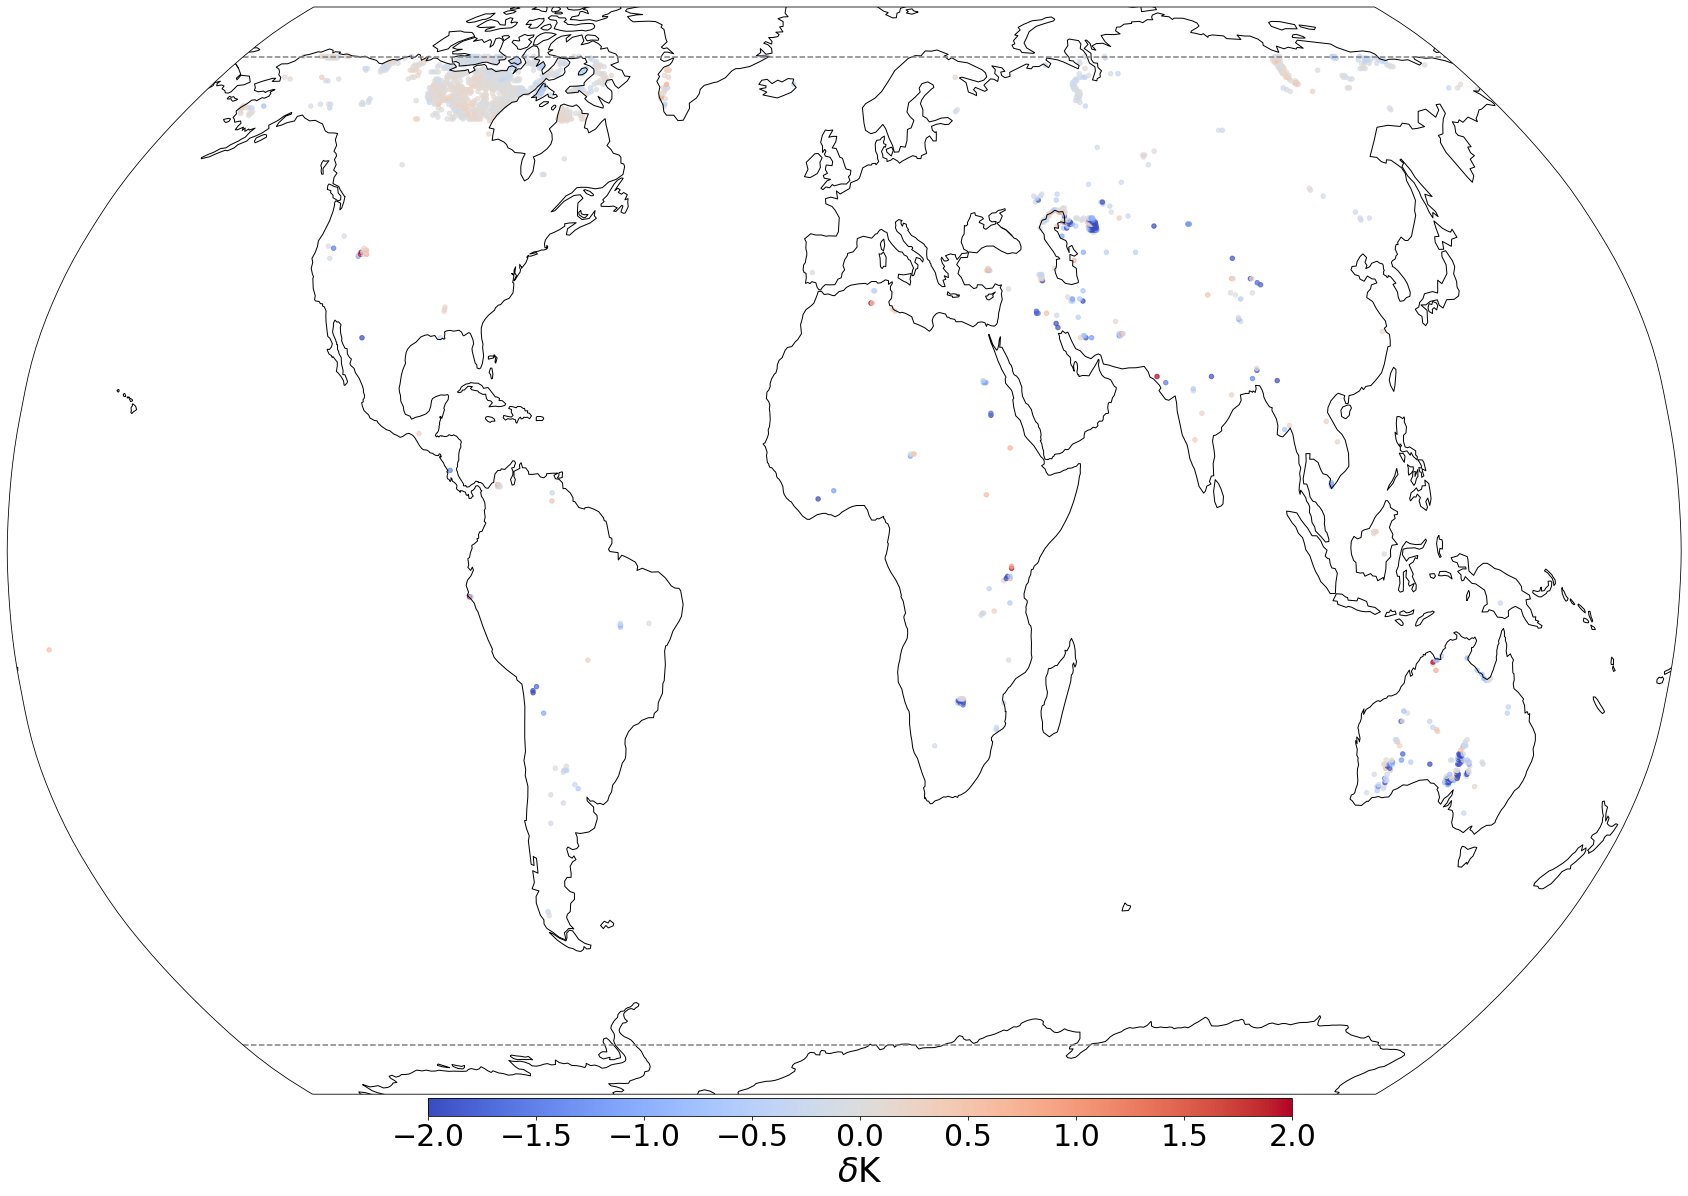

In [85]:
RobinsonPlot(bitstring_1100110,'delta',vmin=-2,vmax=+2,cmap=plt.cm.coolwarm,markersize = 20,savefig='figs/bitstring_100110.png')

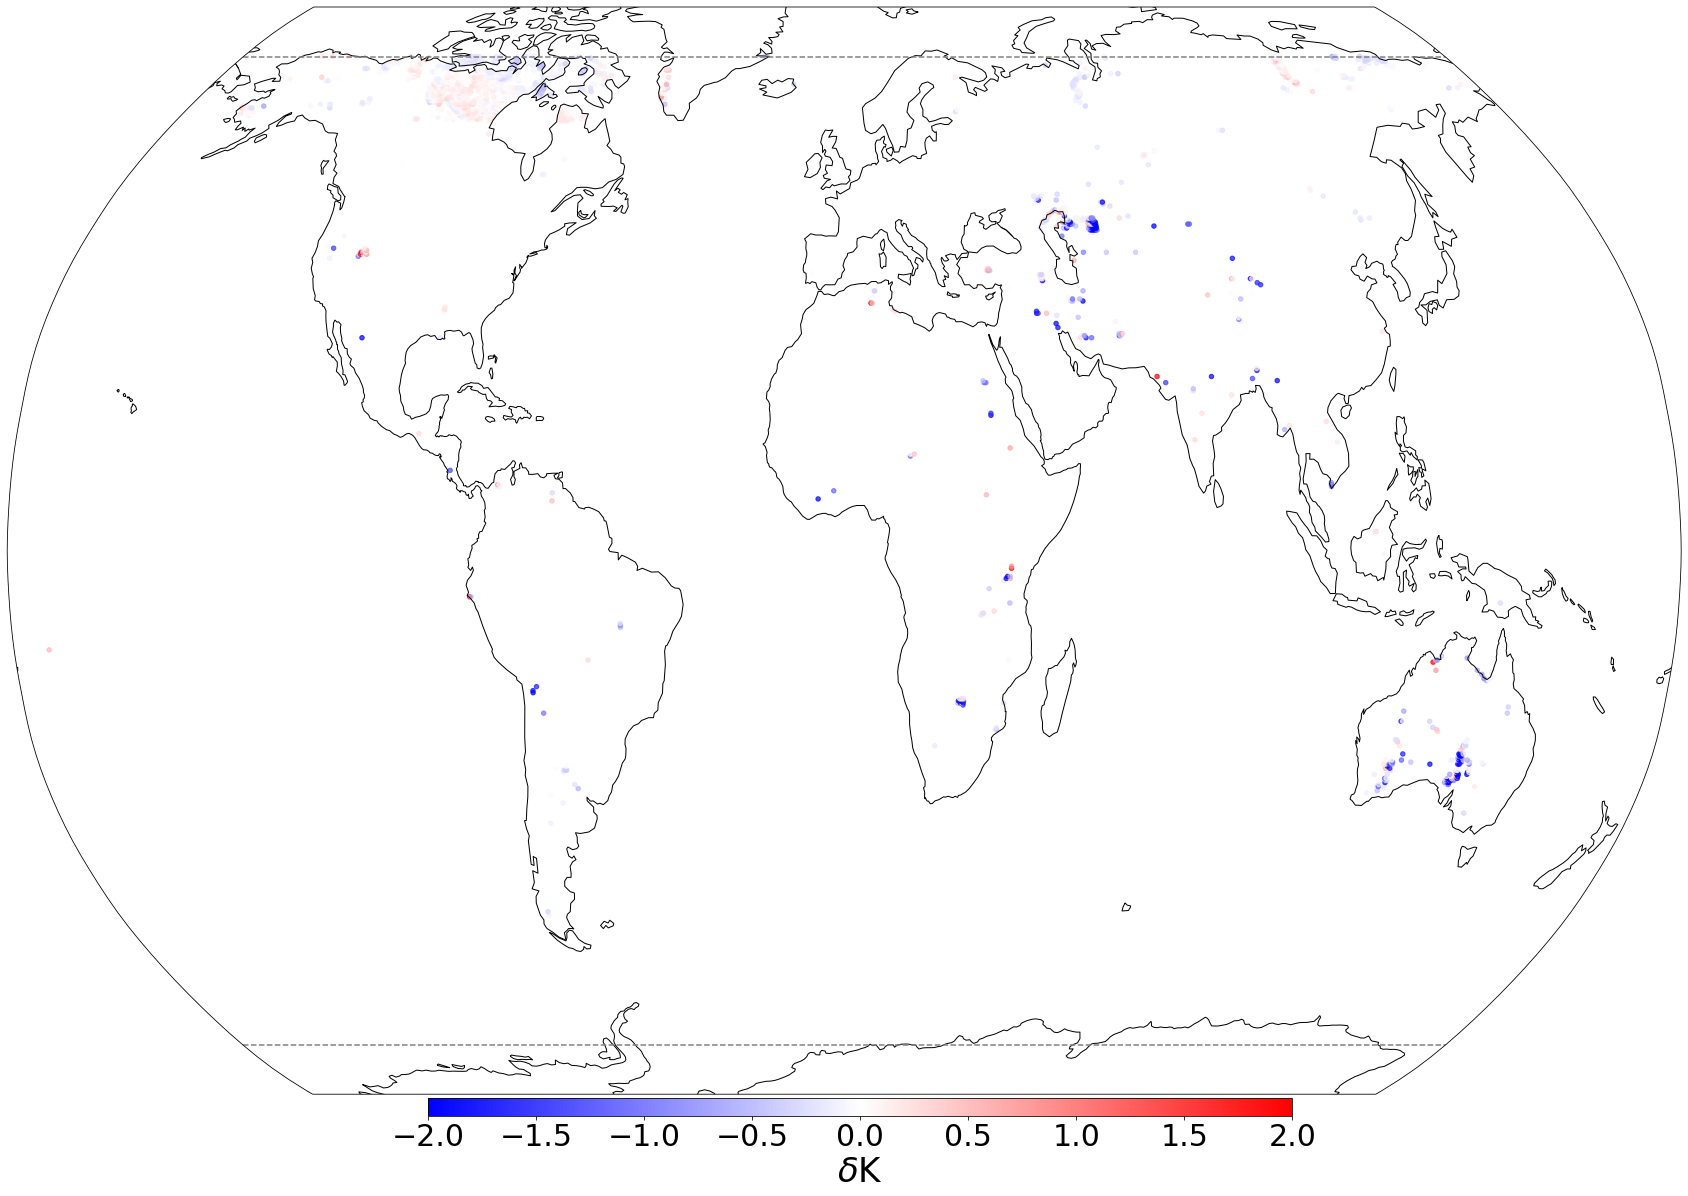

In [86]:
RobinsonPlot(bitstring_1100110,'delta',vmin=-2,vmax=+2,cmap=plt.cm.bwr,markersize = 20,savefig='figs/bitstring_100110_bwr.png')

Lets look at some of the bad points.

In [103]:
bitstring_1100110.query('delta > 1').sort_values(by=['delta'],ascending=False)

,latitude_ERA,longitude_ERA,MODIS_LST,V15_prediction,V20_prediction,V15_error,V20_error,delta,values,step,...,V15_dl,V20_dl,percentage_change_in_dl,cl_change_is_significant,si10_change_is_significant,cvh_change_is_significant,cvl_change_is_significant,lsm_change_is_significant,dl_change_is_significant,bitstring
71529,24.028095,69.00000,313.732483,309.048828,303.119598,5.621420,10.745070,5.123649,162045,0 days,...,2.580078,3.755859,0.455715,True,False,False,False,True,True,100110
101086,41.170945,-113.40000,294.736176,294.245392,302.931915,3.573472,8.450400,4.876928,94518,0 days,...,3.000000,27.000000,8.000000,True,False,False,False,True,True,100110
33374,-6.323183,-80.71875,311.564301,308.391449,304.894409,4.953901,7.726332,2.772430,300193,0 days,...,12.924805,30.428711,1.354288,True,False,False,False,True,True,100110
89090,34.145187,6.08000,309.881317,311.362732,316.291443,3.900536,6.432710,2.532175,120116,0 days,...,20.778320,1.000000,-0.951873,True,False,False,False,True,True,100110
24181,-15.316154,127.96875,315.755646,315.930725,320.098053,2.279654,4.595093,2.315439,340615,0 days,...,22.799805,1.000000,-0.956140,True,False,False,False,True,True,100110
38369,-2.388758,36.00000,317.764832,319.646210,312.096069,4.133606,6.055930,1.922324,281408,0 days,...,6.000000,3.000000,-0.500000,True,False,False,False,True,True,100110
100584,40.889915,-113.40000,296.116394,293.964203,301.534851,3.979623,5.865149,1.885526,95518,0 days,...,3.000000,27.000000,8.000000,True,False,False,False,True,True,100110


In [104]:
#Gujarat
bitstring_1100110.sort_values(by=['delta'],ascending=False).iloc[0]

latitude_ERA                        24.028095
longitude_ERA                            69.0
MODIS_LST                          313.732483
V15_prediction                     309.048828
V20_prediction                     303.119598
V15_error                             5.62142
V20_error                            10.74507
delta                                5.123649
values                                 162045
step                          0 days 00:00:00
surface                                   0.0
latitude                            24.028095
longitude                                69.0
change_in_cl                         0.121381
V15_cl                                0.59056
V20_cl                               0.711941
percentage_change_in_cl              0.205536
heightAboveGround                        10.0
change_in_si10                            0.0
V15_si10                                  0.0
V20_si10                                  0.0
percentage_change_in_si10         

In [105]:
#Salt lake city
bitstring_1100110.sort_values(by=['delta'],ascending=False).iloc[1]

latitude_ERA                        41.170945
longitude_ERA                          -113.4
MODIS_LST                          294.736176
V15_prediction                     294.245392
V20_prediction                     302.931915
V15_error                            3.573472
V20_error                              8.4504
delta                                4.876928
values                                  94518
step                          0 days 00:00:00
surface                                   0.0
latitude                            41.170945
longitude                              -113.4
change_in_cl                        -0.530101
V15_cl                               0.530101
V20_cl                                    0.0
percentage_change_in_cl                  -1.0
heightAboveGround                        10.0
change_in_si10                            0.0
V15_si10                                  0.0
V20_si10                                  0.0
percentage_change_in_si10         

In [106]:
#Peru
bitstring_1100110.sort_values(by=['delta'],ascending=False).iloc[2]

latitude_ERA                        -6.323183
longitude_ERA                       -80.71875
MODIS_LST                          311.564301
V15_prediction                     308.391449
V20_prediction                     304.894409
V15_error                            4.953901
V20_error                            7.726332
delta                                 2.77243
values                                 300193
step                          0 days 00:00:00
surface                                   0.0
latitude                            -6.323183
longitude                           -80.71875
change_in_cl                         0.118985
V15_cl                                    0.0
V20_cl                               0.118985
percentage_change_in_cl                   inf
heightAboveGround                        10.0
change_in_si10                            0.0
V15_si10                                  0.0
V20_si10                                  0.0
percentage_change_in_si10         

The Peru point is a bit odd since both the `cl` AND the `lsm` increase. Lets just do a ver quick check to make sure everything is kosher:

In [114]:

#Get the lat/lon of that point
lat = bitstring_1100110.sort_values(by=['delta'],ascending=False).iloc[2].latitude_ERA
lon = bitstring_1100110.sort_values(by=['delta'],ascending=False).iloc[2].longitude_ERA

In [115]:
#Load the v15 and V20 clake files

root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
version = ['v015', 'v020']
parameter = 'cl'
filename = 'clake'

v = version[0]
path = root+f'climate.{v}/climate.{v}/639l_2/{filename}'
ds_V15= xr.open_dataset(path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName':parameter}) #only want this one parameter
ds_V15 =  ds_V15.assign_coords({"longitude": (((ds_V15.longitude + 180) % 360) - 180)}) #long3 ---> long1
V15_df = ds_V15.to_dataframe().reset_index()

    
v = version[1]
path = root+f'climate.{v}/climate.{v}/639l_2/{filename}'
ds_V20= xr.open_dataset(path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName':parameter}) #only want this one parameter
ds_V20 =  ds_V20.assign_coords({"longitude": (((ds_V20.longitude + 180) % 360) - 180)}) #long3 ---> long1
V20_df = ds_V20.to_dataframe().reset_index()

In [119]:
V15_df.query(f'latitude == {lat} & longitude == {lon}')

,values,time,step,surface,latitude,longitude,valid_time,cl
300193,300193,2013-11-29,0 days,0.0,-6.323183,-80.71875,2013-11-29,0.0


In [120]:
V20_df.query(f'latitude == {lat} & longitude == {lon}')

,values,time,step,surface,latitude,longitude,valid_time,cl
300193,300193,2011-01-31,0 days,0.0,-6.323183,-80.71875,2011-01-31,0.118985


Looks legit...

In [121]:
#Northern Algeria
bitstring_1100110.sort_values(by=['delta'],ascending=False).iloc[3]

latitude_ERA                        34.145187
longitude_ERA                            6.08
MODIS_LST                          309.881317
V15_prediction                     311.362732
V20_prediction                     316.291443
V15_error                            3.900536
V20_error                             6.43271
delta                                2.532175
values                                 120116
step                          0 days 00:00:00
surface                                   0.0
latitude                            34.145187
longitude                                6.08
change_in_cl                        -0.332759
V15_cl                               0.332777
V20_cl                               0.000018
percentage_change_in_cl             -0.999947
heightAboveGround                        10.0
change_in_si10                            0.0
V15_si10                                  0.0
V20_si10                                  0.0
percentage_change_in_si10         

In [196]:
#We will use these below in the V20X section
lat_algeria = bitstring_1100110.sort_values(by=['delta'],ascending=False).iloc[3].latitude_ERA
lon_algeria = bitstring_1100110.sort_values(by=['delta'],ascending=False).iloc[3].longitude_ERA

# 2.1.1 Animation of bitstring 100110

In [122]:
#Bring all relevant data into one df, this time not averaged over the year
data_t = {'latitude_ERA':    V20_predictions.latitude_ERA, 
          'longitude_ERA':   V20_predictions.longitude_ERA,
          'time':            V20_predictions.time,
          'V15_error':       V15_predictions.predicion_error,
          'V20_error':       V20_predictions.predicion_error}
V20_V15_t = pd.DataFrame(data_t)   
V20_V15_t['month'] = pd.DatetimeIndex(V20_V15_t.time).month
V20_V15_t['day'] = pd.DatetimeIndex(V20_V15_t.time).date

In [128]:
V20_V15_t_100110 = pd.merge(V20_V15_t,bitstring_1100110[['latitude_ERA', 'longitude_ERA']],how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude_ERA', 'longitude_ERA']) #inner join.

In [129]:
V20_V15_t_100110

,latitude_ERA,longitude_ERA,time,V15_error,V20_error,month,day
0,60.843060,-161.666667,2019-01-01 00:00:00,8.073914,5.284607,1,2019-01-01
1,60.843060,-161.666667,2019-01-03 00:00:00,2.329361,1.887512,1,2019-01-03
2,60.843060,-161.666667,2019-01-05 00:00:00,5.656189,5.645355,1,2019-01-05
3,60.843060,-161.666667,2019-01-06 00:00:00,4.117920,3.455933,1,2019-01-06
4,60.843060,-161.666667,2019-01-08 00:00:00,4.022705,4.697754,1,2019-01-08
...,...,...,...,...,...,...,...
418387,45.386399,54.000000,2019-12-23 10:00:00,0.237183,4.921204,12,2019-12-23
418388,45.386399,54.000000,2019-12-24 10:00:00,2.936707,8.131256,12,2019-12-24
418389,45.386399,54.000000,2019-12-25 10:00:00,0.587158,7.646423,12,2019-12-25
418390,45.386399,54.000000,2019-12-27 10:00:00,0.432922,4.470398,12,2019-12-27


Jan 2019
Jan 2019
Feb 2019
March 2019
Apr 2019
May 2019
Jun 2019
Jul 2019
Aug 2019
Sept 2019
Oct 2019
Nov 2019
Dec 2019


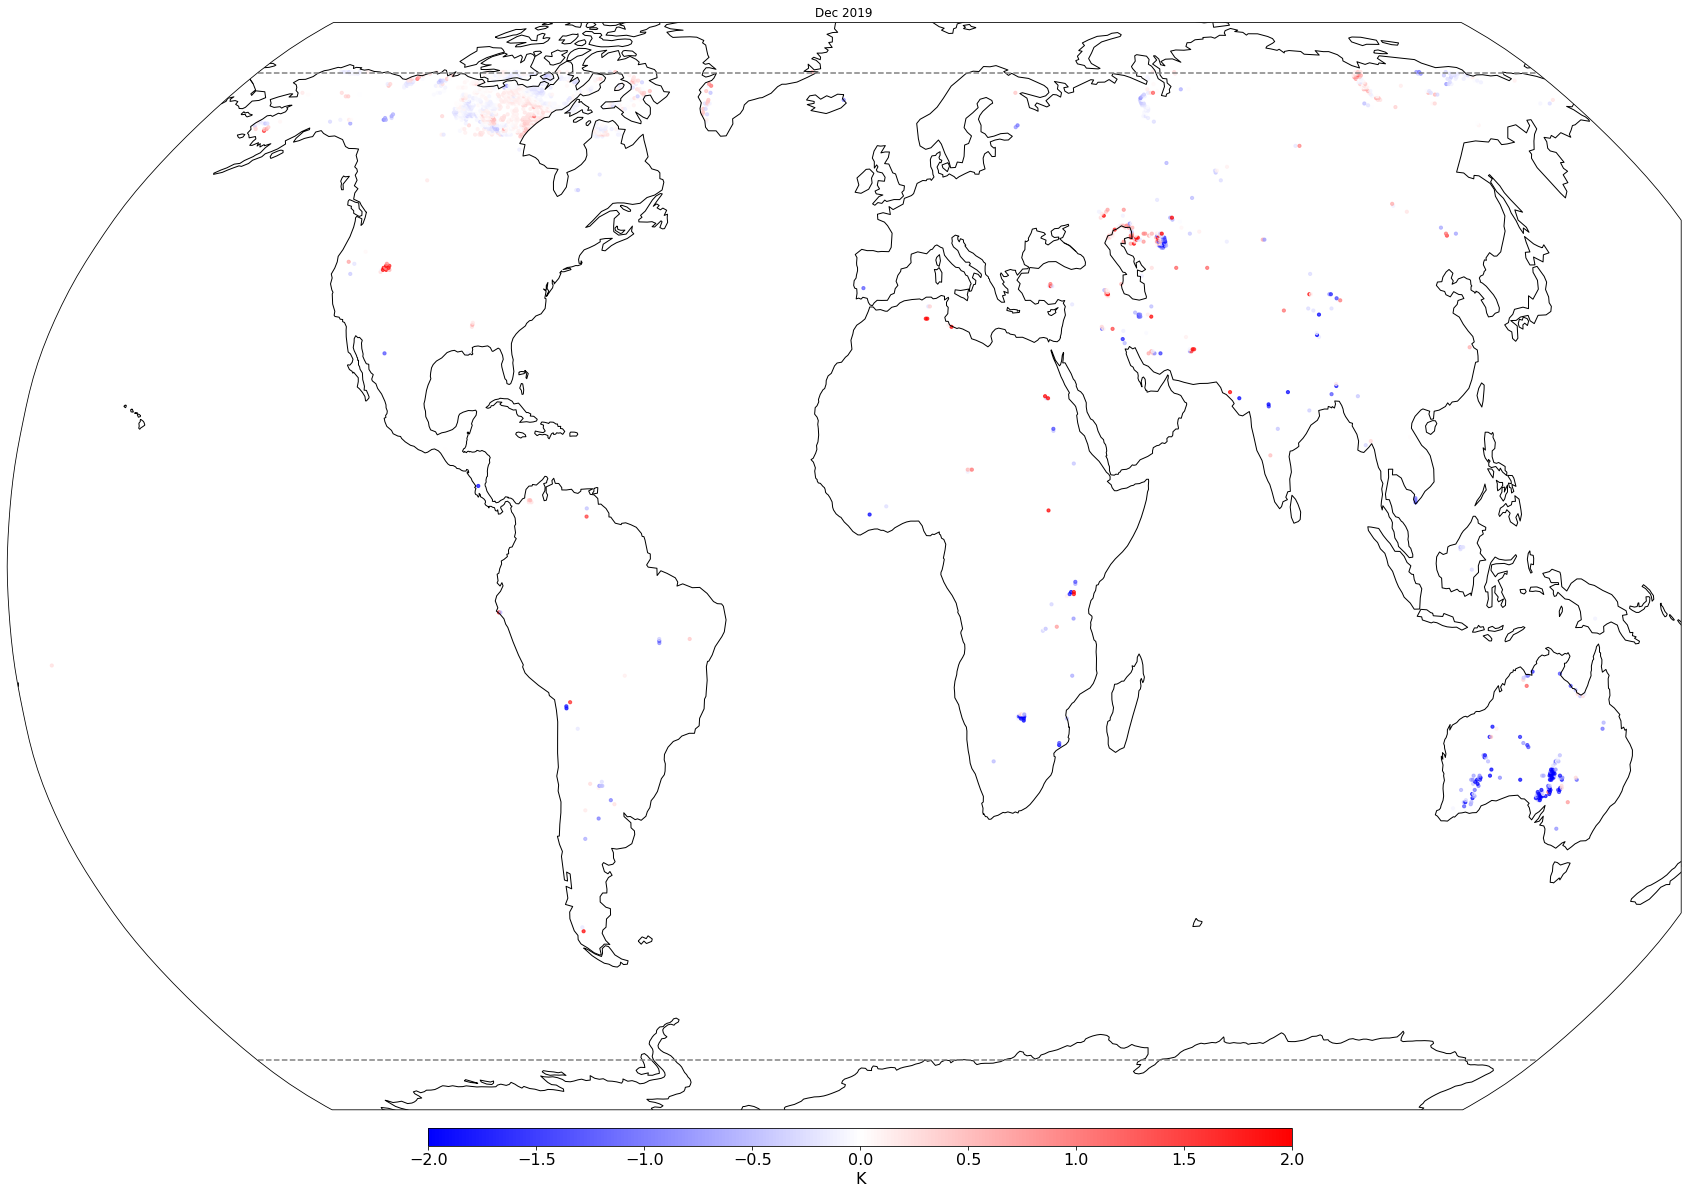

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.colors as mc
import matplotlib.colorbar as cb
import pandas as pd




dftmp = V20_V15_t_100110[['latitude_ERA', 'longitude_ERA', 'month','V20_error', 'V15_error']].copy() #From the timeseries section
dftmp['delta'] =dftmp.V20_error - dftmp.V15_error
ds_map = dftmp.groupby(['latitude_ERA', 'longitude_ERA','month'],as_index=False).mean()



# Data for plotting
t = np.unique(ds_map.month)
frames = len(t)
markersize = 10

#Setup plotting env
fig = plt.figure(figsize=[30,20])
ax = plt.subplot(projection=ccrs.Robinson(central_longitude=0))
cax = fig.add_axes([0.32, 0.10, 0.4, 0.0125])


cmap = plt.cm.bwr
norm = mc.Normalize(vmin=-2, vmax=+2)
cb1 = cb.ColorbarBase(cax, cmap=cmap,
                           norm=norm,
                           orientation='horizontal'
                           )



titles = ['Jan 2019','Feb 2019','March 2019','Apr 2019','May 2019','Jun 2019',
         'Jul 2019','Aug 2019','Sept 2019','Oct 2019','Nov 2019','Dec 2019']
    
    

def update(i):
    # clear the axis each frame
    ax.clear()
    
     
    #Get the data
    ti=t[i]
    condition = f"month == {ti}"
    ds = ds_map.query(condition)
    
    
    
    
    #Get data
    x = ds['latitude_ERA']
    y = ds['longitude_ERA']
    z1 = ds['delta']
    
    

        
    
    # replot things
    sc = ax.scatter(y,x,transform=ccrs.PlateCarree(),
                    s=markersize,
                    c=cmap(norm(z1)),
                    linewidths=1, 
                    alpha=.7)

    title = titles[i]
    print(title)
    ax.set_title(title)

    #Latitude cutoffs
    ax.plot([-180,180],[70,70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')
    ax.plot([-180,180],[-70,-70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')


    #Formatting
    cax.tick_params(labelsize=16)
    cax.set_xlabel('K',fontsize=16)

    ax.coastlines()
    ax.set_aspect('auto') #Force projection aspect ratio



# print('Animating')
ani = animation.FuncAnimation(fig, update, frames=frames, interval=500)
ani.save('figs/animation_monthly_v20_V15_100110.mp4')










# 2.2 Bitstring 000101

In [132]:
bitstring_000101 = V20_V15_annual_average_categorized.query('bitstring == "000101"')

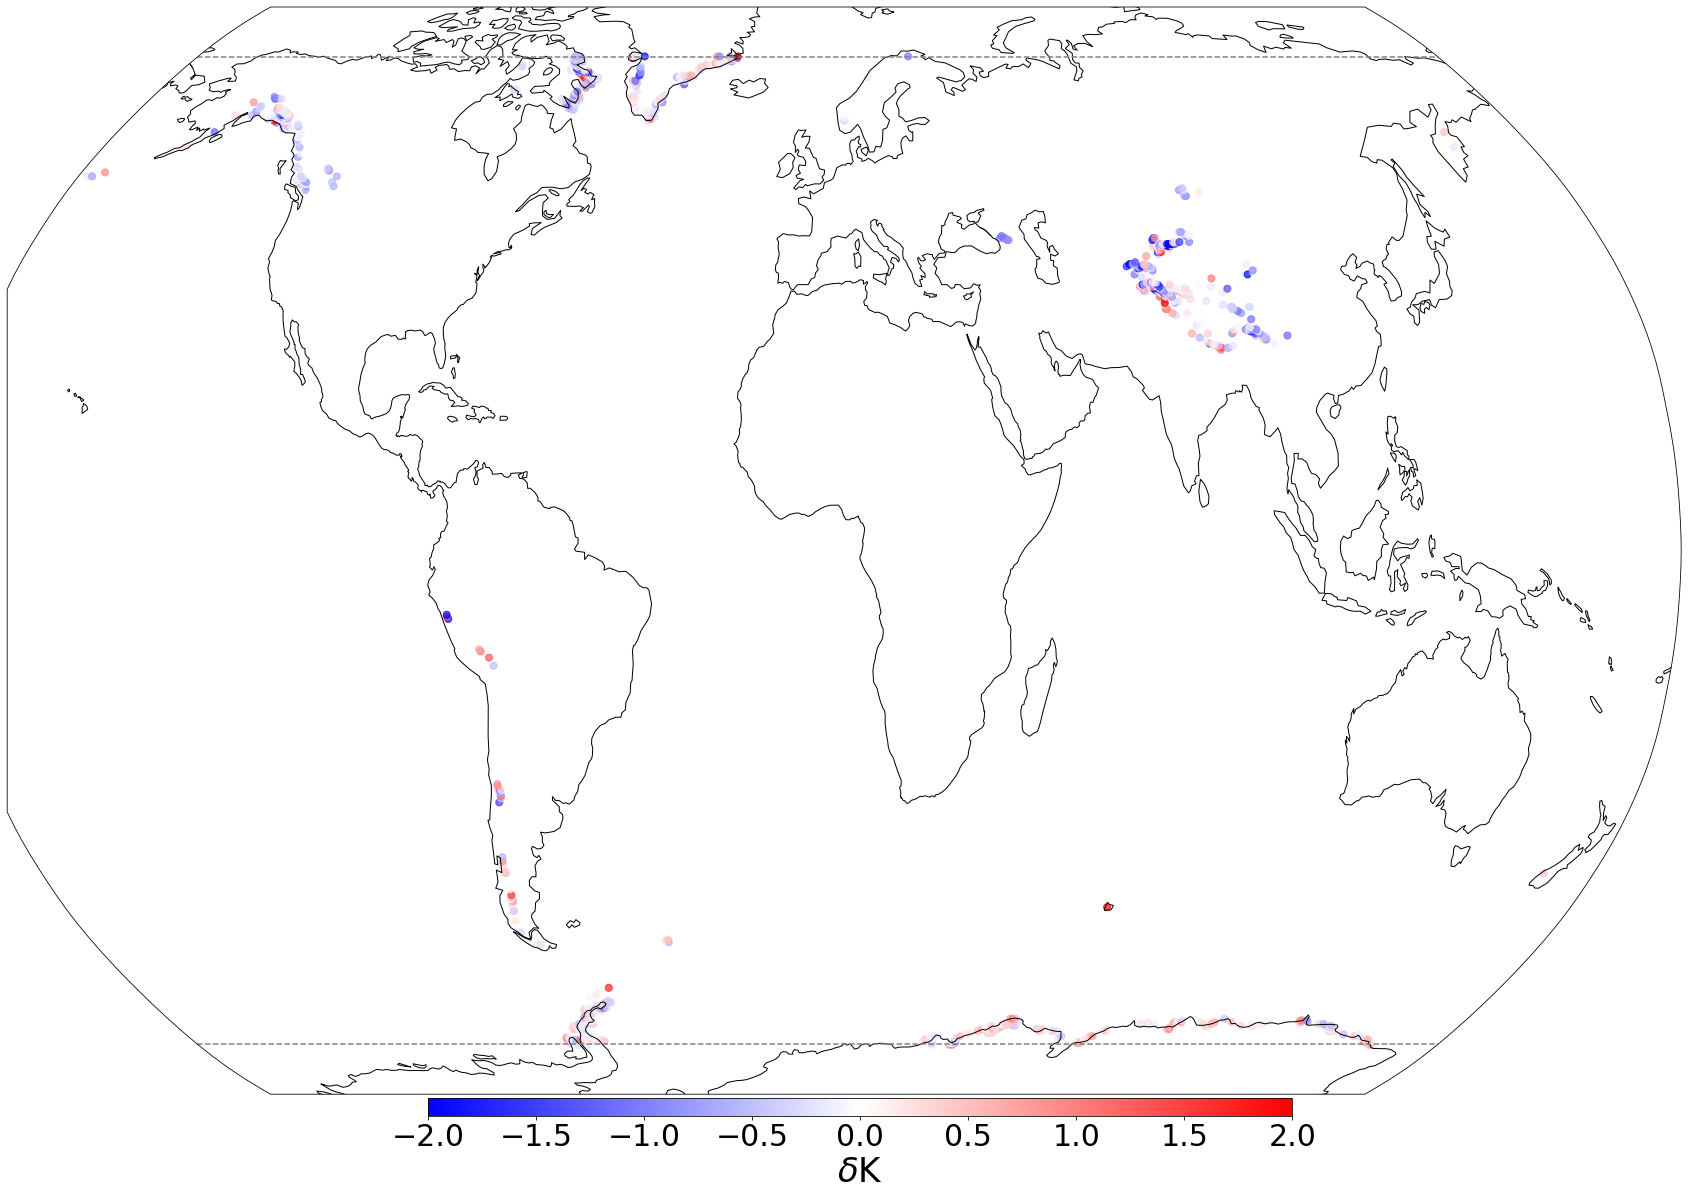

In [134]:
RobinsonPlot(bitstring_000101,'delta',vmin=-2,vmax=+2,cmap=plt.cm.bwr,markersize = 50,savefig=None)

In [147]:
bitstring_000101.sort_values(by=['delta'],ascending=False).iloc[0]

latitude_ERA                         59.99997
longitude_ERA                     -141.866667
MODIS_LST                          271.977448
V15_prediction                     277.694244
V20_prediction                     261.428802
V15_error                            6.214495
V20_error                           10.868941
delta                                4.654447
values                                  37428
step                          0 days 00:00:00
surface                                   0.0
latitude                             59.99997
longitude                         -141.866667
change_in_cl                          0.00121
V15_cl                                    0.0
V20_cl                                0.00121
percentage_change_in_cl                   inf
heightAboveGround                        10.0
change_in_si10                       0.112061
V15_si10                             0.164856
V20_si10                             0.276917
percentage_change_in_si10         

# 2.3 Bitstring 010100


In [148]:
bitstring_010100 = V20_V15_annual_average_categorized.query('bitstring == "010100"')

In [154]:
bitstring_010100.sort_values(by=['delta'],ascending=False).iloc[4]

latitude_ERA                        -0.983606
longitude_ERA                        98.71875
MODIS_LST                          299.748657
V15_prediction                     299.439484
V20_prediction                     311.325012
V15_error                            2.597664
V20_error                           11.576346
delta                                8.978683
values                                 275231
step                          0 days 00:00:00
surface                                   0.0
latitude                            -0.983606
longitude                            98.71875
change_in_cl                         0.000036
V15_cl                                    0.0
V20_cl                               0.000036
percentage_change_in_cl                   inf
heightAboveGround                        10.0
change_in_si10                            0.0
V15_si10                                  0.0
V20_si10                                  0.0
percentage_change_in_si10         

In [155]:
bitstring_010100.sort_values(by=['delta'],ascending=False).iloc[5]

latitude_ERA                       -37.798581
longitude_ERA                      148.666667
MODIS_LST                          293.302094
V15_prediction                     291.919373
V20_prediction                     304.229431
V15_error                            2.645613
V20_error                           10.927361
delta                                8.281747
values                                 435389
step                          0 days 00:00:00
surface                                   0.0
latitude                           -37.798581
longitude                          148.666667
change_in_cl                         0.007793
V15_cl                                    0.0
V20_cl                               0.007793
percentage_change_in_cl                   inf
heightAboveGround                        10.0
change_in_si10                            0.0
V15_si10                                  0.0
V20_si10                                  0.0
percentage_change_in_si10         

---



# 3. V20X

Now lets look at the augmented V20 model which has monthly maps and salt lake maps. 

In [156]:
V20X_model = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V20_2016_augmented_monthlyclake/'

print ('----------V20X----------')
V20X_predictions,V20X_predictions_averaged = load_predictions(V20X_model)

----------V20X----------
Mean/Median/Std prediction bias: 0.018071566 0.15356445 3.9607246
Mean/Median/Std prediction error: 2.9511783 2.2535706 2.6416352


In [164]:
#Create a new df that will just hold the differences   
dataX = {'latitude_ERA':    V20X_predictions_averaged.latitude_ERA, 
         'longitude_ERA':   V20X_predictions_averaged.longitude_ERA,
         'MODIS_LST':       V20X_predictions_averaged.MODIS_LST,
         'V20_prediction':  V15_predictions_averaged.predictions,
         'V20X_prediction': V20X_predictions_averaged.predictions,
         'V20_error':       V15_predictions_averaged.predicion_error,
         'V20X_error':      V20X_predictions_averaged.predicion_error,
         'delta':           V20X_predictions_averaged.predicion_error - V15_predictions_averaged.predicion_error}
V20X_V20_annual_average = pd.DataFrame(dataX)   

In [165]:
V20X_V20_annual_average_categorized = pd.merge(V20X_V20_annual_average,change_in_fields,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.

In [166]:
#Classification table. For each group/bitstring surface some numbers
classification_tableX                                = V20X_V20_annual_average_categorized.groupby('bitstring').agg(**{'Number of Pixels':pd.NamedAgg('delta','size'),'AverageDelta':pd.NamedAgg('delta','mean')})     # For each group, count number of pixels and get the average delta      
classification_tableX["Percentage"]                  = 100.0* classification_tableX['Number of Pixels'] / sum(classification_tableX["Number of Pixels"])                                            # Express number of pixels as a percentage
classification_tableX['Stats (t-statistic,p-value)'] = V20X_V20_annual_average_categorized.groupby('bitstring').apply(lambda x: significance_test(x['V20_error'], x['V20X_error']))                                     # For each group, do a ttest between the V15_errors and the V20_errors
classification_tableX['Significant Change?']         = classification_tableX['Stats (t-statistic,p-value)'].apply(lambda x: significance_boolean(x))

display(classification_tableX[['Number of Pixels', 'Percentage','AverageDelta','Stats (t-statistic,p-value)','Significant Change?']].sort_values(by=['Significant Change?', 'Number of Pixels'],ascending=False))



/home/k/kimpson/bin/conda/envs/workhorse/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/k/kimpson/bin/conda/envs/workhorse/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


,Number of Pixels,Percentage,AverageDelta,"Stats (t-statistic,p-value)",Significant Change?
bitstring,,,,,
000100,135005,90.117482,-0.081465,"(23.56030193871013, 1.3102858471844417e-122)",Significant
000000,9119,6.087044,-0.104934,"(6.350991251617155, 2.189890540772654e-10)",Significant
100100,2392,1.596689,-0.111606,"(4.718440796562972, 2.4443631137646333e-06)",Significant
100110,1512,1.009278,-0.395243,"(7.593134806378133, 4.135401079128569e-14)",Significant
000101,834,0.556705,-0.284028,"(4.890430864789042, 1.1031513823102672e-06)",Significant
100000,234,0.156198,-0.270278,"(2.896794175583813, 0.003947403841422364)",Significant
000110,247,0.164876,-0.194843,"(2.0249189795464706, 0.043415219271146346)",Insignificant
000111,114,0.076096,-0.082715,"(0.6609266848660991, 0.5093324991958698)",Insignificant
100010,104,0.069421,-0.192760,"(1.7034173947827063, 0.0899980578333079)",Insignificant


In [167]:
bitstringX_1100110 = V20X_V20_annual_average_categorized.query('bitstring == "100110"')

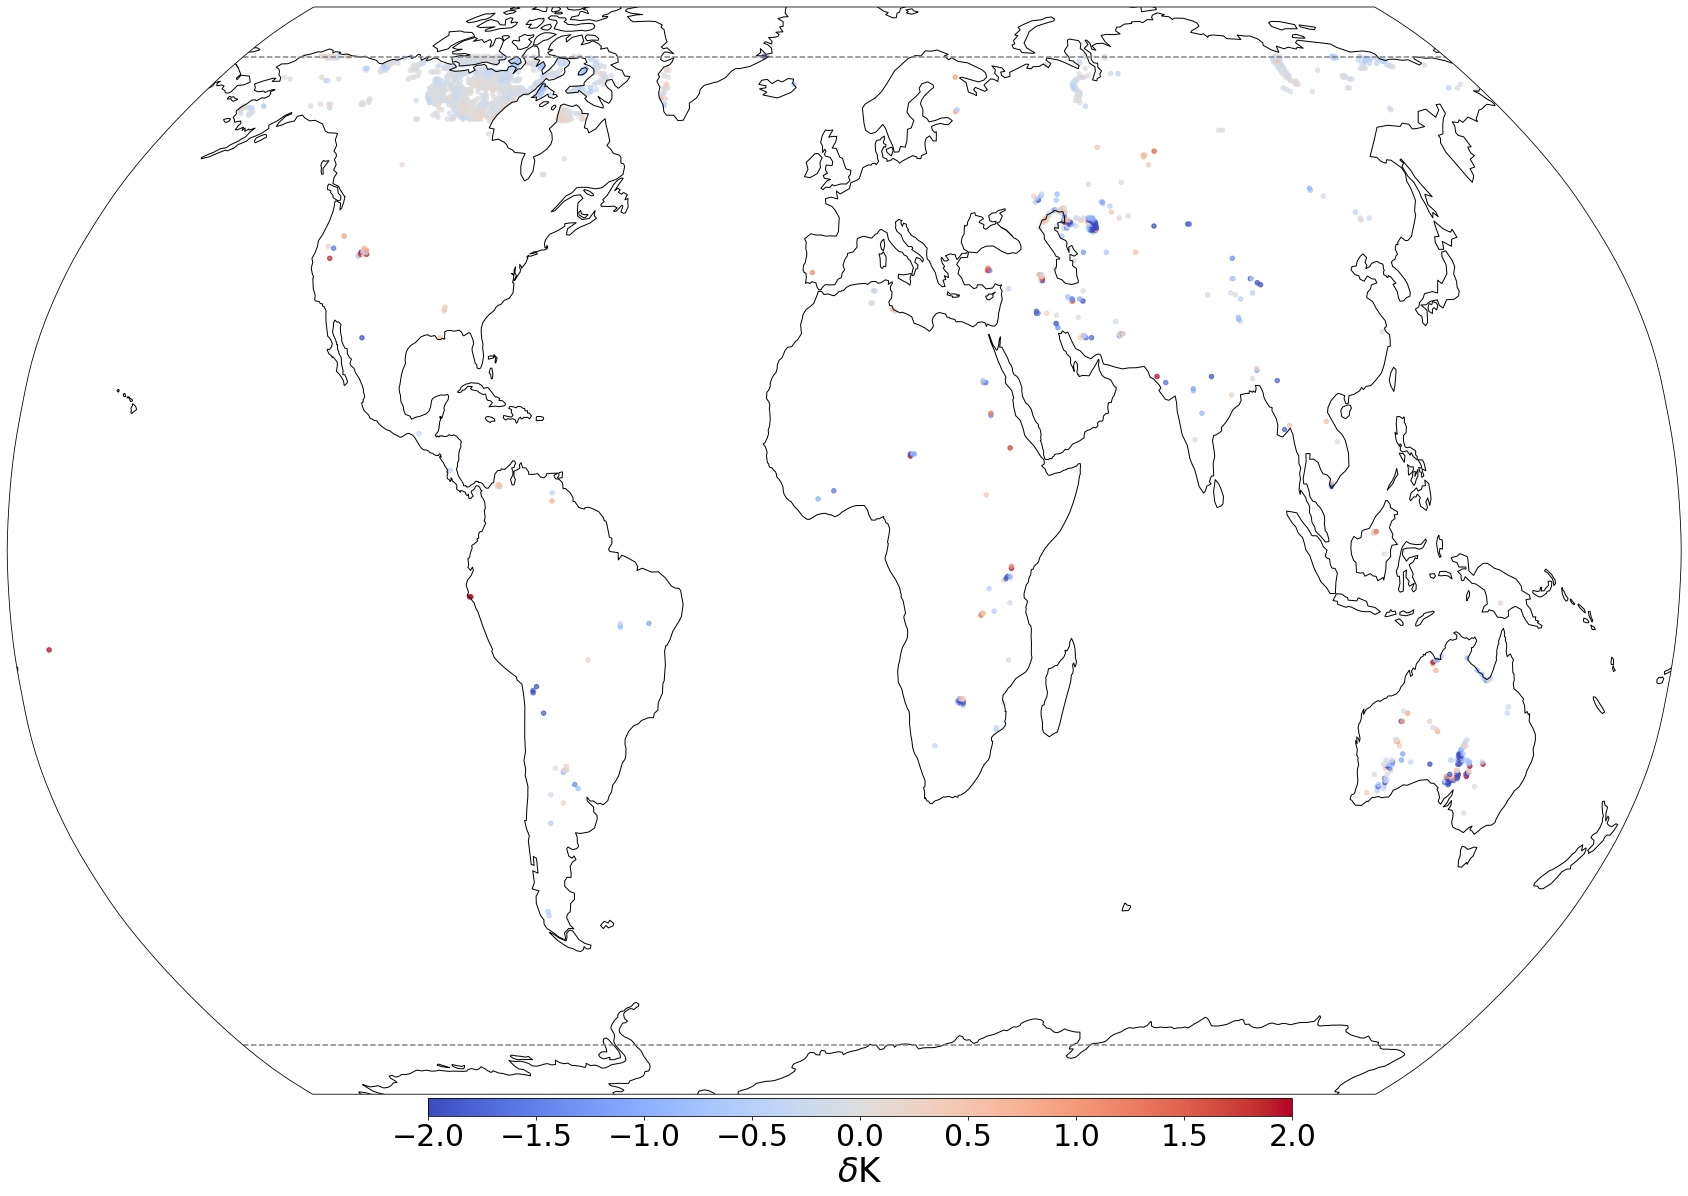

In [194]:
RobinsonPlot(bitstringX_1100110,'delta',vmin=-2,vmax=+2,cmap=plt.cm.coolwarm,markersize = 20,savefig='figs/bitstringX_100110.png')

In [198]:
bitstringX_1100110.query(f'latitude_ERA == {lat_algeria} & longitude_ERA == {lon_algeria}')

,latitude_ERA,longitude_ERA,MODIS_LST,V20_prediction,V20X_prediction,V20_error,V20X_error,delta,values,step,...,V15_dl,V20_dl,percentage_change_in_dl,cl_change_is_significant,si10_change_is_significant,cvh_change_is_significant,cvl_change_is_significant,lsm_change_is_significant,dl_change_is_significant,bitstring
89090,34.145187,6.08,309.881317,311.362732,310.715393,3.900536,4.158387,0.257852,120116,0 days,...,20.77832,1.0,-0.951873,True,False,False,False,True,True,100110


In [199]:
bitstring_1100110.query(f'latitude_ERA == {lat_algeria} & longitude_ERA == {lon_algeria}')

,latitude_ERA,longitude_ERA,MODIS_LST,V15_prediction,V20_prediction,V15_error,V20_error,delta,values,step,...,V15_dl,V20_dl,percentage_change_in_dl,cl_change_is_significant,si10_change_is_significant,cvh_change_is_significant,cvl_change_is_significant,lsm_change_is_significant,dl_change_is_significant,bitstring
89090,34.145187,6.08,309.881317,311.362732,316.291443,3.900536,6.43271,2.532175,120116,0 days,...,20.77832,1.0,-0.951873,True,False,False,False,True,True,100110


In [206]:
bitstringX_100000 = V20X_V20_annual_average_categorized.query('bitstring == "100000"')

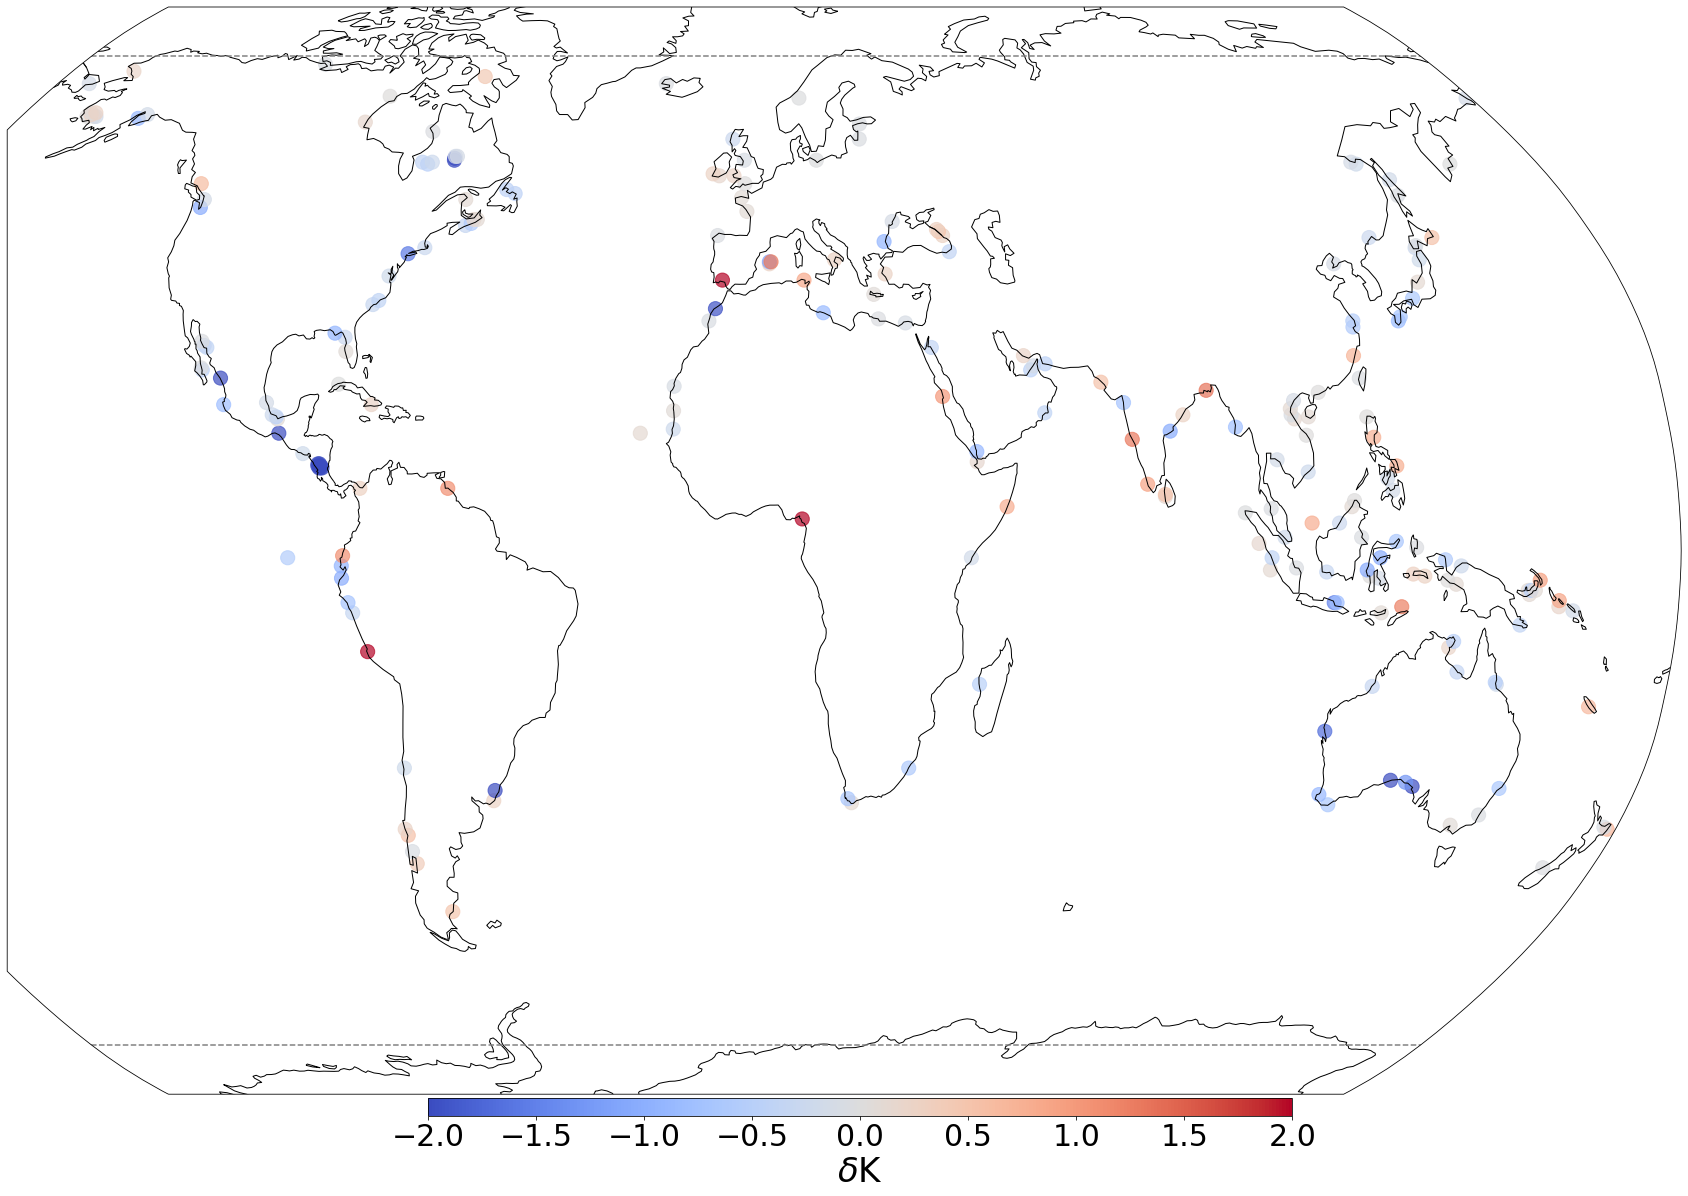

In [208]:
RobinsonPlot(bitstringX_100000,'delta',vmin=-2,vmax=+2,cmap=plt.cm.coolwarm,markersize = 200,savefig=None)

# 4. Timeseries plots

In [209]:
#Create a timeseries

data_timeseries = {'latitude_ERA':    V20_predictions.latitude_ERA, 
                   'longitude_ERA':   V20_predictions.longitude_ERA,
                   'time':            V20_predictions.time,
                   'V15_error':       V15_predictions.predicion_error,
                   'V20_error':       V20_predictions.predicion_error,
                   'V20X_error':      V20X_predictions.predicion_error}
df_timeseries = pd.DataFrame(data_timeseries)   
df_timeseries['month'] = pd.DatetimeIndex(df_timeseries.time).month
df_timeseries['day'] = pd.DatetimeIndex(df_timeseries.time).date

In [210]:
df_timeseries_categorized = pd.merge(df_timeseries,change_in_fields,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.

In [225]:
import seaborn as sns

def plot_timeseries(df,condition):
    
    df_category = df.query(condition)

    
    #V15
    dfV15 = df_category[['latitude_ERA','longitude_ERA', 'month', 'V15_error']].copy()
    dfV15 = dfV15.rename(columns={'V15_error':'error'})
    dfV15['model'] = 'V15'

    #V20
    dfV20 = df_category[['latitude_ERA','longitude_ERA', 'month', 'V20_error']].copy()
    dfV20 = dfV20.rename(columns={'V20_error':'error'})
    dfV20['model'] = 'V20'

    #V20X
    dfV20X = df_category[['latitude_ERA','longitude_ERA', 'month', 'V20X_error']].copy()
    dfV20X = dfV20X.rename(columns={'V20X_error':'error'})
    dfV20X['model'] = 'V20X'
    
    dfs_monthly = pd.concat([dfV15, dfV20, dfV20X])

    
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))

    p = sns.lineplot(data=dfs_monthly.reset_index(), x="month", y='error',hue='model', style='model', ci=99,ax=ax1,markers=True)
    ax1.set_xlabel("Month")
    ax1.set_ylabel("Mean Prediction Error (K)")
    ax1.legend().set_title(None)


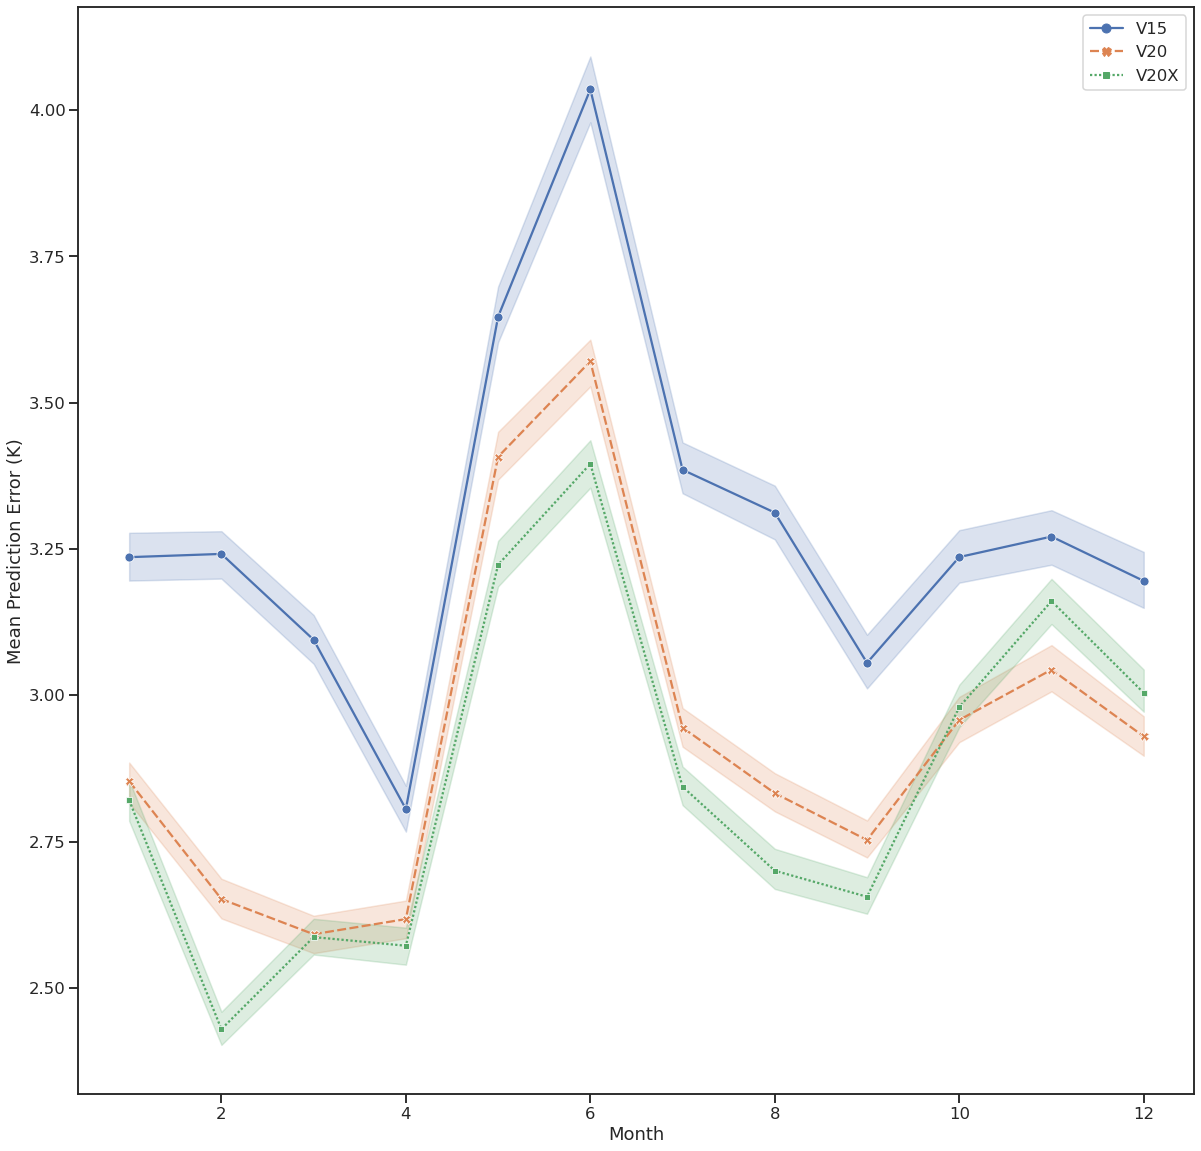

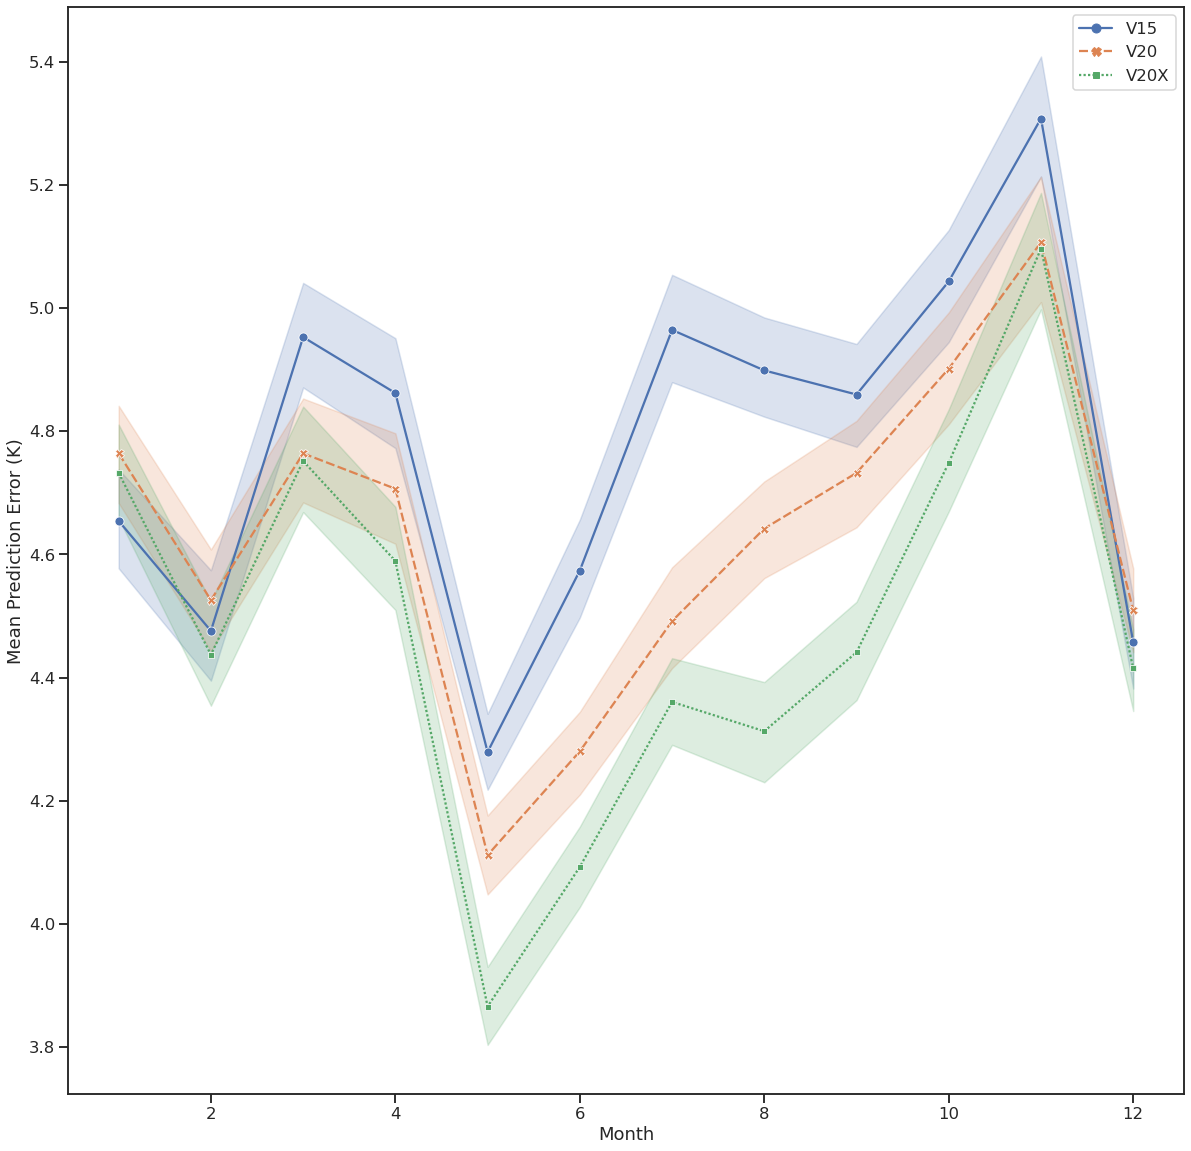

In [226]:
plot_timeseries(df_timeseries_categorized,'bitstring == "100110"')
plot_timeseries(df_timeseries_categorized,'bitstring == "000101"')

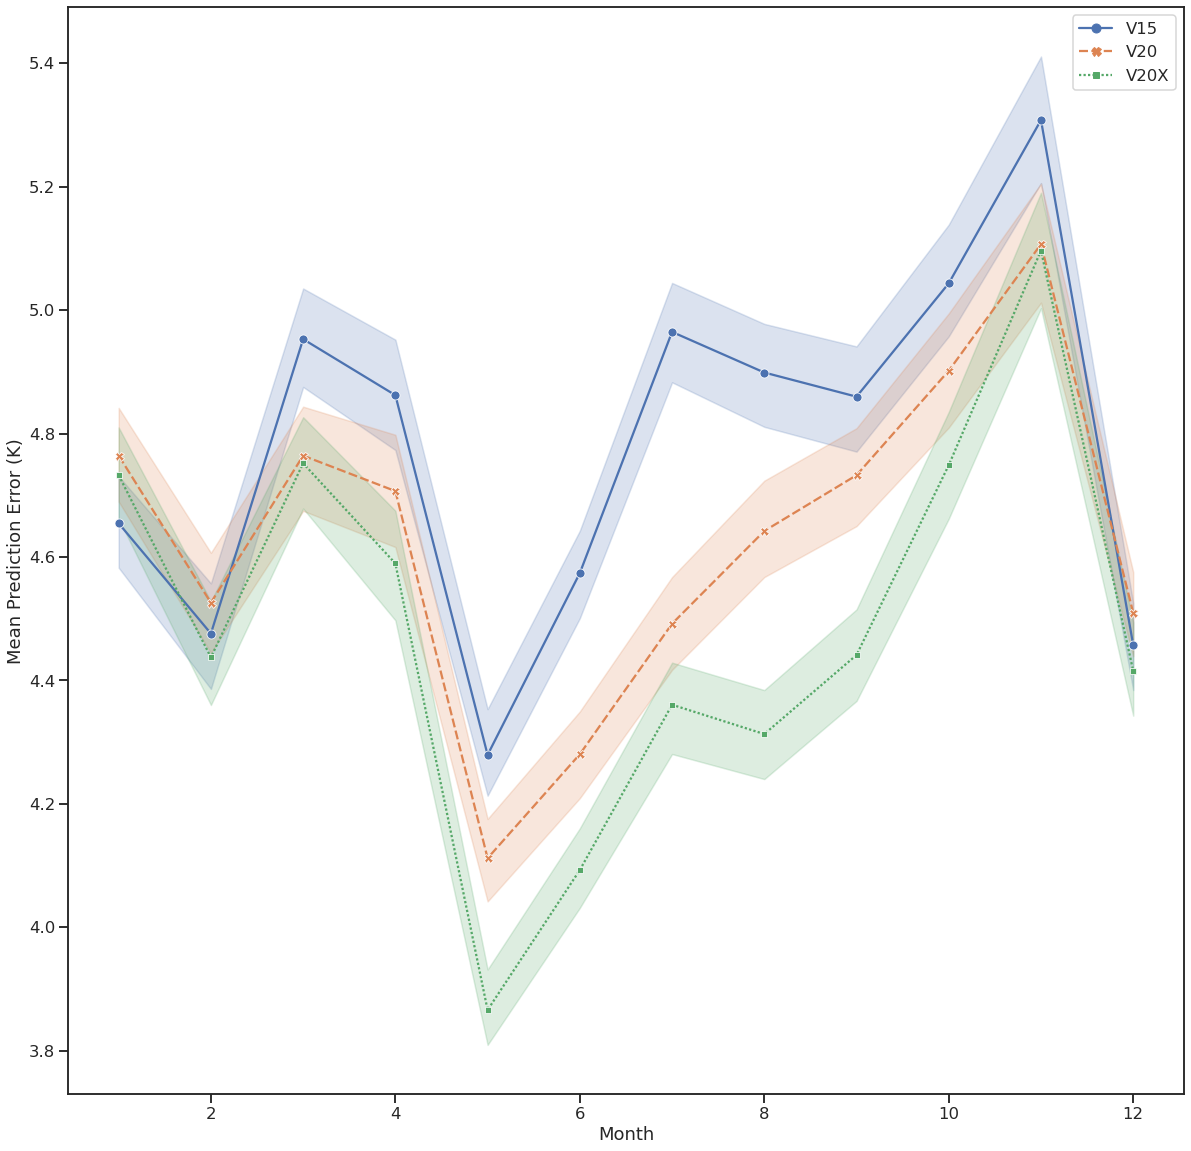